### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [4]:
batch_size = 4 #受限于贫穷，3是极限了
learning_rate = 0.0001
target_size = 256
epochs = 1

In [5]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [6]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [7]:
model = VGG16()

In [8]:
model.load_state_dict(torch.load("./model/MPFA_56.pth"), strict=False)

<All keys matched successfully>

In [9]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

model.train()

# layers = [model.conv1_1, model.conv1_2, model.conv2_1, model.conv2_2,
#          model.conv3_1, model.conv3_2, model.conv3_3,
#          model.conv4_1, model.conv4_2, model.conv4_3,
#          model.conv5_1, model.conv5_2, model.conv5_3]

# for layer in layers:
#     for par in layer.parameters():
#         par.requires_grad = False

VGG16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling1): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling2): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpooling3): MaxPool2d(kernel_size=2, stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1,

In [10]:
for epoch in range(57, 61):
    criterion = EdgeHoldLoss().to(device)
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                weight_decay=0,
                                momentum=0.9)
    print("lr:{:.10f}".format(learning_rate))
    start_time = time.time()
    learning_rate = learning_rate - learning_rate * 0.1
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}"
                      .format(epoch, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")
    torch.save(model.state_dict(),"./model/MPFA_{}.pth".format(epoch))

lr:0.0001000000
Epoch:57 loss:0.42703038454055786 Batch:100/2639 acc:0.9133535027503967 pre:0.9261622428894043 recall:0.8436447978019714 F-measure:0.901913583278656
Epoch:57 loss:0.4211007356643677 Batch:200/2639 acc:0.9151515960693359 pre:0.9221832752227783 recall:0.8475654125213623 F-measure:0.9006873965263367
Epoch:57 loss:0.4275614023208618 Batch:300/2639 acc:0.9167395234107971 pre:0.9232199192047119 recall:0.8462100028991699 F-measure:0.9015415906906128
Epoch:57 loss:0.42983323335647583 Batch:400/2639 acc:0.917376697063446 pre:0.9233244061470032 recall:0.8459271788597107 F-measure:0.9014611840248108
Epoch:57 loss:0.4215114712715149 Batch:500/2639 acc:0.9175869822502136 pre:0.9244339466094971 recall:0.8484172224998474 F-measure:0.9031612277030945
Epoch:57 loss:0.426814466714859 Batch:600/2639 acc:0.9177424311637878 pre:0.924286425113678 recall:0.8498620986938477 F-measure:0.9035322070121765
Epoch:57 loss:0.4126969575881958 Batch:700/2639 acc:0.9176116585731506 pre:0.923768281936645

lr:0.0000810000
Epoch:59 loss:0.42475852370262146 Batch:100/2639 acc:0.9201775789260864 pre:0.9350197911262512 recall:0.8647087812423706 F-measure:0.9162704348564148
Epoch:59 loss:0.42108631134033203 Batch:200/2639 acc:0.9205248951911926 pre:0.9297510981559753 recall:0.8660311102867126 F-measure:0.9124537706375122
Epoch:59 loss:0.41773444414138794 Batch:300/2639 acc:0.9192141890525818 pre:0.9298262596130371 recall:0.866491436958313 F-measure:0.9125069379806519
Epoch:59 loss:0.43331536650657654 Batch:400/2639 acc:0.9195747375488281 pre:0.9281909465789795 recall:0.8631561994552612 F-measure:0.9103052020072937
Epoch:59 loss:0.428527295589447 Batch:500/2639 acc:0.9206318855285645 pre:0.9279433488845825 recall:0.8647064566612244 F-measure:0.910362958908081
Epoch:59 loss:0.42643436789512634 Batch:600/2639 acc:0.92027348279953 pre:0.9279915690422058 recall:0.8625165820121765 F-measure:0.9099088907241821
Epoch:59 loss:0.4283774495124817 Batch:700/2639 acc:0.9195985794067383 pre:0.9264471530914

In [11]:
# torch.save(model.state_dict(),"./model/MPFA_47.pth")

In [12]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [13]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [14]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [15]:
msk.shape

torch.Size([256, 256, 1])

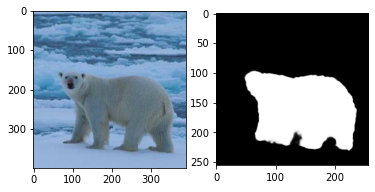

In [16]:
img = getInput("./image/1.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

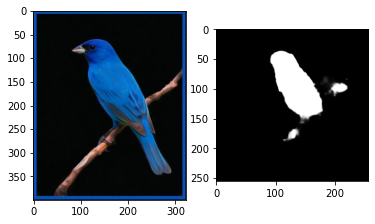

In [17]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

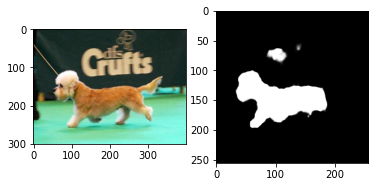

In [18]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()